**Import necessary libraries**

In [1]:
import pickle
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import svm 
import sklearn
%matplotlib inline

**Helper functions to load the CIFAR-10 batches**

In [4]:

"""
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. 
There are 50000 training images and 10000 test images.The dataset is divided into five training batches
and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images
from each class. The training batches contain the remaining images in random order, but some training batches
may contain more images from one class than another. Between them, the training batches contain exactly 5000 
images from each class.
"""
def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

def load_CIFAR10_Data(data_dir, negatives=False):
    meta_data_dict = unpickle(data_dir + "/batches.meta")
    labels = meta_data_dict[b'label_names']
    labels = np.array(labels)

    # Train data
    X_train = None
    train_filenames = []
    y_train = []

    for i in range(1, 6):
        X_train_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            X_train = X_train_dict[b'data']
        else:
            X_train = np.vstack((X_train, X_train_dict[b'data']))
        train_filenames += X_train_dict[b'filenames']
        y_train += X_train_dict[b'labels']

    X_train = X_train.reshape((len(X_train), 3, 32, 32))
    X_train = np.rollaxis(X_train, 1, 4)
    y_train = np.array(y_train)

    # Test data
    X_test_dict = unpickle(data_dir + "/test_batch")
    X_test = X_test_dict[b'data']    
    y_test = X_test_dict[b'labels']

    X_test = X_test.reshape((len(X_test), 3, 32, 32))
    X_test = np.rollaxis(X_test, 1, 4)   
    y_test = np.array(y_test)

    return X_train, y_train,X_test,y_test, labels

Train and Test splits

In [25]:
cifar_10_dir = r'Datasets\Question-1\cifar-10-batches-py'
X_train, y_train,X_test,y_test, labels=load_CIFAR10_Data(cifar_10_dir)

In [6]:
def getNormalizedImages(X_train, X_test):
    # X_train = np.reshape(X_train,(50000,3072))
    # X_test = np.reshape(X_test,(10000,3072))
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    
    # Normalization of pixel values (to [0-1] range)    
    X_train /= 255
    X_test /= 255
    
    return X_train,X_test

In [7]:
X_train,X_test=getNormalizedImages(X_train, X_test)

Details of Train and Test images with  visualization of sample images

Train data:  (50000, 32, 32, 3)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test labels:  (10000,)
Label names:  (10,)
Train Data Sample:
Size:(32, 32, 3)
Label:b'ship'


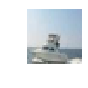

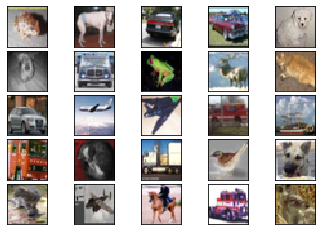

In [8]:
print("Train data: ", X_train.shape)

print("Train labels: ", y_train.shape)
print("Test data: ", X_test.shape)

print("Test labels: ", y_test.shape)
print("Label names: ", labels.shape)

print('Train Data Sample:')
row=100

print('Size:' + str(X_train[row].shape))
print('Label:' + str(labels[y_train[row]]))
plt.figure(figsize = (1,1))
plt.axis('off')
plt.imshow(X_train[row])
plt.show()

# display some random training images in a 25x25 grid
num_plot = 5
f, ax = plt.subplots(num_plot, num_plot)
for m in range(num_plot):
    for n in range(num_plot):
        idx = np.random.randint(0, X_train.shape[0])
        ax[m, n].imshow(X_train[idx])
        ax[m, n].get_xaxis().set_visible(False)
        ax[m, n].get_yaxis().set_visible(False)
f.subplots_adjust(hspace=0.1)
f.subplots_adjust(wspace=0)
plt.show()

Featurize the images as vectors that can be used for classification.

In [9]:
def getVectorizedImages(X_train, X_test):
    X_train = np.reshape(X_train,(50000,3072))
    X_test = np.reshape(X_test,(10000,3072))
    return X_train,X_test

In [19]:
X_train,X_test=getVectorizedImages(X_train, X_test)

In [20]:
X_train.shape

(50000, 3072)

SVM Accuracy ,F1 Score and Confusin Matrix

In [13]:
def getScore(y_actual,y_pred):
    acc = sklearn.metrics.accuracy_score(y_actual, y_pred)
    f1=sklearn.metrics.f1_score(y_actual, y_pred, average='micro')
    cm=sklearn.metrics.confusion_matrix(y_actual, y_pred)
    return acc,f1,cm

def getSVMPredictions(X_train, y_train,X_test,y_test,filename,c=0.1):
    ## Training
    clf = svm.SVC(kernel='linear', C=c,verbose=True, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    
    pickle.dump(clf, open(filename, 'wb'))
   
    ##Train Scores
    y_pred_train = clf.predict(X_train)
    acc_train,f1_train,cm_train=getScore(y_train,y_pred_train)
    ## Test scores 
    y_pred_test = clf.predict(X_test)
    acc_test,f1_test,cm_test=getScore(y_test,y_pred_test)

    return acc_train,f1_train,cm_train,acc_test,f1_test,cm_test

def getKNNPredictions(X_train, y_train,X_test,y_test,filename):
    ## Training 
    clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)
  
    pickle.dump(clf, open(filename, 'wb'))
   
    ##Train Scores
    y_pred_train = clf.predict(X_train)
    acc_train,f1_train,cm_train=getScore(y_train,y_pred_train)
    ## Test scores 
    y_pred_test = clf.predict(X_test)
    acc_test,f1_test,cm_test=getScore(y_test,y_pred_test)

    return acc_train,f1_train,cm_train,acc_test,f1_test,cm_test

In [150]:
tic = time.time()
acc_train,f1_train,cm_train,acc_test,f1_test,cm_test=getSVMPredictions(X_train, y_train,X_test,y_test,'svm_naive.pkl')
toc = time.time()

[LibSVM]

In [ ]:
print('Training scores')
print( 'Accuracy: %f' % (acc_train*100 ))
print( 'f1 score: %f' % (f1_train ))
print( 'Confusion matrix :',cm_train)

print('Test scores')
print( 'Accuracy: %f' % (acc_test*100 ))
print( 'f1 score: %f' % (f1_test ))
print( 'Confusion matrix :',cm_test)

In [152]:
tic = time.time()
acc_train,f1_train,cm_train,acc_test,f1_test,cm_test==getKNNPredictions(X_train, y_train,X_test,y_test,'knn_naive.pkl')
toc = time.time()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [ ]:
print('Training scores')
print( 'Accuracy: %f' % (acc_train*100 ))
print( 'f1 score: %f' % (f1_train ))
print( 'Confusion matrix :',cm_train)

print('Test scores')
print( 'Accuracy: %f' % (acc_test*100 ))
print( 'f1 score: %f' % (f1_test ))
print( 'Confusion matrix :',cm_test)

**Desktop Run**

    Accuracy: 0.439800, and gradient: computed in 15041.063489s (4 hours) -SVM
    Accuracy: 0.339800, and gradient: computed in 3364.487147s (56 minutes) -KNN

SVM has better accuracy than KNN in this case

In [0]:
# def svc_param_selection(X, y, nfolds,kernel_type):
#     Cs = [0.001, 0.01, 0.1, 1, 10]
#     gammas = [0.001, 0.01, 0.1, 1]
#     param_grid = {'C': Cs, 'gamma' : gammas}
#     grid_search = GridSearchCV(svm.SVC(kernel=kernel_type), param_grid, cv=nfolds,n_jobs=-1,verbose=2)
#     grid_search.fit(X, y)
#     grid_search.best_params_
#     return grid_search.best_params_

In [0]:
# nfolds=5
# kernel_type='linear'
# svc_param_selection(X_train, y_train, nfolds,kernel_type)


In [0]:
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
def getSVMPredictions2(X_train, y_train,X_test,y_test):
    ## Training
    #svc = svm.SVC()
    #svc.fit(X_train, y_train)
    n_estimators = 10
    start = time.time()
    #https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python
    clf = OneVsRestClassifier(BaggingClassifier(svm.SVC(kernel='linear', C=0.1,verbose=True, class_weight='balanced'),n_jobs=-1, max_samples=1.0 / n_estimators, n_estimators=n_estimators))   
    clf.fit(X_train, y_train)
    end = time.time()
    print ("Bagging SVC", end - start, clf.score(X_train, y_train))
    
    filename = 'svn_baggin_model.pkl'
    pickle.dump(clf, open(filename, 'wb'))

    ##Train Scores
    y_pred_train = clf.predict(X_train)
    acc_train,f1_train,cm_train=getScore(y_train,y_pred_train)
    ## Test scores 
    y_pred_test = clf.predict(X_test)
    acc_test,f1_test,cm_test=getScore(y_test,y_pred_test)

    return acc_train,f1_train,cm_train,acc_test,f1_test,cm_test

Using HOG decriptor as features as method get reprentative features as the dataset is large.
Not all features are useful for training

In [21]:
from skimage.feature import hog
from skimage.color import rgb2gray
def getHOGDescriptor(images):
    hogDescriptors = []    
    for image in images:
        #print(len(hogDescriptors))
        gray = rgb2gray(image)
        fd, _ = hog(gray, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualise=True)
        hogDescriptors.append(fd)        

    hogDescriptors = np.squeeze(hogDescriptors)
    return hogDescriptors

In [26]:
X_train, y_train,X_test,y_test, labels=load_CIFAR10_Data(cifar_10_dir)

print("Extracting HOG descriptors for the training set...")
tic = time.time()
trainHogDescriptors = getHOGDescriptor(X_train)
toc = time.time()
print("Took: " + str(toc - tic) + " sec")

Extracting HOG descriptors for the training set...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


C:\anaconda3\lib\site-packages\skimage\feature\_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302

1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099


3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759


5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415


6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092


8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752


10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313
10314
10315
10316
10317
10318
10319
10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
1036

11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
1176

12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100
13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113
13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128
13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
1315

14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455
14456
14457
14458
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498
14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510
14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523
14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535
14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549
14550
14551
14552
14553
14554
14555
1455

15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
15803
15804
15805
15806
15807
15808
15809
15810
15811
15812
15813
15814
15815
15816
15817
15818
15819
15820
15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
1593

17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
17152
17153
17154
17155
17156
17157
17158
17159
17160
17161
17162
17163
17164
17165
17166
17167
17168
17169
17170
17171
17172
17173
17174
17175
17176
17177
17178
17179
17180
17181
17182
17183
17184
17185
17186
17187
17188
17189
17190
17191
17192
17193
17194
17195
17196
17197
17198
17199
17200
17201
17202
17203
17204
17205
17206
17207
17208
17209
17210
17211
17212
17213
17214
17215
17216
17217
17218
17219
17220
17221
17222
17223
17224
17225
17226
17227
17228
17229
17230
17231
17232
17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
17243
17244
17245
17246
17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
17257
17258
17259
17260
17261
17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273
17274
17275
17276
17277
17278
17279
17280
17281
17282
17283
17284
17285
17286
17287
17288
17289
17290
17291
17292
17293
17294
17295
17296
17297
17298
17299
17300
17301
17302
17303
17304
17305
17306
17307
1730

18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
18531
18532
18533
18534
18535
18536
18537
18538
18539
18540
18541
18542
18543
18544
18545
18546
18547
18548
18549
18550
18551
18552
18553
18554
18555
18556
18557
18558
18559
18560
18561
18562
18563
18564
18565
18566
18567
18568
18569
18570
18571
18572
18573
18574
18575
18576
18577
18578
18579
18580
18581
18582
18583
18584
18585
18586
18587
18588
18589
18590
18591
18592
18593
18594
18595
18596
18597
18598
18599
18600
18601
18602
18603
18604
18605
18606
18607
18608
18609
18610
18611
18612
18613
18614
18615
18616
18617
18618
18619
18620
18621
18622
18623
18624
18625
18626
18627
18628
18629
18630
18631
18632
18633
18634
18635
18636
18637
18638
18639
18640
18641
18642
18643
18644
18645
18646
18647
18648
18649
18650
18651
18652
18653
18654
18655
18656
18657
18658
18659
18660
18661
18662
18663
18664
18665
18666
18667
18668
18669
18670
18671
18672
18673
18674
18675
18676
18677
18678
18679
18680
18681
1868

19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
19973
19974
19975
19976
19977
19978
19979
19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993
19994
19995
19996
19997
19998
19999
20000
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20014
20015
20016
20017
20018
20019
20020
20021
20022
20023
20024
20025
20026
20027
20028
20029
20030
20031
20032
20033
20034
20035
20036
20037
20038
20039
20040
20041
20042
20043
20044
20045
20046
20047
20048
20049
20050
20051
20052
20053
20054
20055
20056
20057
20058
20059
20060
20061
20062
20063
20064
20065
20066
20067
20068
20069
20070
20071
20072
20073
20074
2007

21304
21305
21306
21307
21308
21309
21310
21311
21312
21313
21314
21315
21316
21317
21318
21319
21320
21321
21322
21323
21324
21325
21326
21327
21328
21329
21330
21331
21332
21333
21334
21335
21336
21337
21338
21339
21340
21341
21342
21343
21344
21345
21346
21347
21348
21349
21350
21351
21352
21353
21354
21355
21356
21357
21358
21359
21360
21361
21362
21363
21364
21365
21366
21367
21368
21369
21370
21371
21372
21373
21374
21375
21376
21377
21378
21379
21380
21381
21382
21383
21384
21385
21386
21387
21388
21389
21390
21391
21392
21393
21394
21395
21396
21397
21398
21399
21400
21401
21402
21403
21404
21405
21406
21407
21408
21409
21410
21411
21412
21413
21414
21415
21416
21417
21418
21419
21420
21421
21422
21423
21424
21425
21426
21427
21428
21429
21430
21431
21432
21433
21434
21435
21436
21437
21438
21439
21440
21441
21442
21443
21444
21445
21446
21447
21448
21449
21450
21451
21452
21453
21454
21455
21456
21457
21458
21459
21460
21461
21462
21463
21464
21465
21466
21467
21468
21469
2147

22684
22685
22686
22687
22688
22689
22690
22691
22692
22693
22694
22695
22696
22697
22698
22699
22700
22701
22702
22703
22704
22705
22706
22707
22708
22709
22710
22711
22712
22713
22714
22715
22716
22717
22718
22719
22720
22721
22722
22723
22724
22725
22726
22727
22728
22729
22730
22731
22732
22733
22734
22735
22736
22737
22738
22739
22740
22741
22742
22743
22744
22745
22746
22747
22748
22749
22750
22751
22752
22753
22754
22755
22756
22757
22758
22759
22760
22761
22762
22763
22764
22765
22766
22767
22768
22769
22770
22771
22772
22773
22774
22775
22776
22777
22778
22779
22780
22781
22782
22783
22784
22785
22786
22787
22788
22789
22790
22791
22792
22793
22794
22795
22796
22797
22798
22799
22800
22801
22802
22803
22804
22805
22806
22807
22808
22809
22810
22811
22812
22813
22814
22815
22816
22817
22818
22819
22820
22821
22822
22823
22824
22825
22826
22827
22828
22829
22830
22831
22832
22833
22834
22835
22836
22837
22838
22839
22840
22841
22842
22843
22844
22845
22846
22847
22848
22849
2285

24059
24060
24061
24062
24063
24064
24065
24066
24067
24068
24069
24070
24071
24072
24073
24074
24075
24076
24077
24078
24079
24080
24081
24082
24083
24084
24085
24086
24087
24088
24089
24090
24091
24092
24093
24094
24095
24096
24097
24098
24099
24100
24101
24102
24103
24104
24105
24106
24107
24108
24109
24110
24111
24112
24113
24114
24115
24116
24117
24118
24119
24120
24121
24122
24123
24124
24125
24126
24127
24128
24129
24130
24131
24132
24133
24134
24135
24136
24137
24138
24139
24140
24141
24142
24143
24144
24145
24146
24147
24148
24149
24150
24151
24152
24153
24154
24155
24156
24157
24158
24159
24160
24161
24162
24163
24164
24165
24166
24167
24168
24169
24170
24171
24172
24173
24174
24175
24176
24177
24178
24179
24180
24181
24182
24183
24184
24185
24186
24187
24188
24189
24190
24191
24192
24193
24194
24195
24196
24197
24198
24199
24200
24201
24202
24203
24204
24205
24206
24207
24208
24209
24210
24211
24212
24213
24214
24215
24216
24217
24218
24219
24220
24221
24222
24223
24224
2422

25462
25463
25464
25465
25466
25467
25468
25469
25470
25471
25472
25473
25474
25475
25476
25477
25478
25479
25480
25481
25482
25483
25484
25485
25486
25487
25488
25489
25490
25491
25492
25493
25494
25495
25496
25497
25498
25499
25500
25501
25502
25503
25504
25505
25506
25507
25508
25509
25510
25511
25512
25513
25514
25515
25516
25517
25518
25519
25520
25521
25522
25523
25524
25525
25526
25527
25528
25529
25530
25531
25532
25533
25534
25535
25536
25537
25538
25539
25540
25541
25542
25543
25544
25545
25546
25547
25548
25549
25550
25551
25552
25553
25554
25555
25556
25557
25558
25559
25560
25561
25562
25563
25564
25565
25566
25567
25568
25569
25570
25571
25572
25573
25574
25575
25576
25577
25578
25579
25580
25581
25582
25583
25584
25585
25586
25587
25588
25589
25590
25591
25592
25593
25594
25595
25596
25597
25598
25599
25600
25601
25602
25603
25604
25605
25606
25607
25608
25609
25610
25611
25612
25613
25614
25615
25616
25617
25618
25619
25620
25621
25622
25623
25624
25625
25626
25627
2562

26831
26832
26833
26834
26835
26836
26837
26838
26839
26840
26841
26842
26843
26844
26845
26846
26847
26848
26849
26850
26851
26852
26853
26854
26855
26856
26857
26858
26859
26860
26861
26862
26863
26864
26865
26866
26867
26868
26869
26870
26871
26872
26873
26874
26875
26876
26877
26878
26879
26880
26881
26882
26883
26884
26885
26886
26887
26888
26889
26890
26891
26892
26893
26894
26895
26896
26897
26898
26899
26900
26901
26902
26903
26904
26905
26906
26907
26908
26909
26910
26911
26912
26913
26914
26915
26916
26917
26918
26919
26920
26921
26922
26923
26924
26925
26926
26927
26928
26929
26930
26931
26932
26933
26934
26935
26936
26937
26938
26939
26940
26941
26942
26943
26944
26945
26946
26947
26948
26949
26950
26951
26952
26953
26954
26955
26956
26957
26958
26959
26960
26961
26962
26963
26964
26965
26966
26967
26968
26969
26970
26971
26972
26973
26974
26975
26976
26977
26978
26979
26980
26981
26982
26983
26984
26985
26986
26987
26988
26989
26990
26991
26992
26993
26994
26995
26996
2699

28219
28220
28221
28222
28223
28224
28225
28226
28227
28228
28229
28230
28231
28232
28233
28234
28235
28236
28237
28238
28239
28240
28241
28242
28243
28244
28245
28246
28247
28248
28249
28250
28251
28252
28253
28254
28255
28256
28257
28258
28259
28260
28261
28262
28263
28264
28265
28266
28267
28268
28269
28270
28271
28272
28273
28274
28275
28276
28277
28278
28279
28280
28281
28282
28283
28284
28285
28286
28287
28288
28289
28290
28291
28292
28293
28294
28295
28296
28297
28298
28299
28300
28301
28302
28303
28304
28305
28306
28307
28308
28309
28310
28311
28312
28313
28314
28315
28316
28317
28318
28319
28320
28321
28322
28323
28324
28325
28326
28327
28328
28329
28330
28331
28332
28333
28334
28335
28336
28337
28338
28339
28340
28341
28342
28343
28344
28345
28346
28347
28348
28349
28350
28351
28352
28353
28354
28355
28356
28357
28358
28359
28360
28361
28362
28363
28364
28365
28366
28367
28368
28369
28370
28371
28372
28373
28374
28375
28376
28377
28378
28379
28380
28381
28382
28383
28384
2838

29620
29621
29622
29623
29624
29625
29626
29627
29628
29629
29630
29631
29632
29633
29634
29635
29636
29637
29638
29639
29640
29641
29642
29643
29644
29645
29646
29647
29648
29649
29650
29651
29652
29653
29654
29655
29656
29657
29658
29659
29660
29661
29662
29663
29664
29665
29666
29667
29668
29669
29670
29671
29672
29673
29674
29675
29676
29677
29678
29679
29680
29681
29682
29683
29684
29685
29686
29687
29688
29689
29690
29691
29692
29693
29694
29695
29696
29697
29698
29699
29700
29701
29702
29703
29704
29705
29706
29707
29708
29709
29710
29711
29712
29713
29714
29715
29716
29717
29718
29719
29720
29721
29722
29723
29724
29725
29726
29727
29728
29729
29730
29731
29732
29733
29734
29735
29736
29737
29738
29739
29740
29741
29742
29743
29744
29745
29746
29747
29748
29749
29750
29751
29752
29753
29754
29755
29756
29757
29758
29759
29760
29761
29762
29763
29764
29765
29766
29767
29768
29769
29770
29771
29772
29773
29774
29775
29776
29777
29778
29779
29780
29781
29782
29783
29784
29785
2978

30994
30995
30996
30997
30998
30999
31000
31001
31002
31003
31004
31005
31006
31007
31008
31009
31010
31011
31012
31013
31014
31015
31016
31017
31018
31019
31020
31021
31022
31023
31024
31025
31026
31027
31028
31029
31030
31031
31032
31033
31034
31035
31036
31037
31038
31039
31040
31041
31042
31043
31044
31045
31046
31047
31048
31049
31050
31051
31052
31053
31054
31055
31056
31057
31058
31059
31060
31061
31062
31063
31064
31065
31066
31067
31068
31069
31070
31071
31072
31073
31074
31075
31076
31077
31078
31079
31080
31081
31082
31083
31084
31085
31086
31087
31088
31089
31090
31091
31092
31093
31094
31095
31096
31097
31098
31099
31100
31101
31102
31103
31104
31105
31106
31107
31108
31109
31110
31111
31112
31113
31114
31115
31116
31117
31118
31119
31120
31121
31122
31123
31124
31125
31126
31127
31128
31129
31130
31131
31132
31133
31134
31135
31136
31137
31138
31139
31140
31141
31142
31143
31144
31145
31146
31147
31148
31149
31150
31151
31152
31153
31154
31155
31156
31157
31158
31159
3116

32361
32362
32363
32364
32365
32366
32367
32368
32369
32370
32371
32372
32373
32374
32375
32376
32377
32378
32379
32380
32381
32382
32383
32384
32385
32386
32387
32388
32389
32390
32391
32392
32393
32394
32395
32396
32397
32398
32399
32400
32401
32402
32403
32404
32405
32406
32407
32408
32409
32410
32411
32412
32413
32414
32415
32416
32417
32418
32419
32420
32421
32422
32423
32424
32425
32426
32427
32428
32429
32430
32431
32432
32433
32434
32435
32436
32437
32438
32439
32440
32441
32442
32443
32444
32445
32446
32447
32448
32449
32450
32451
32452
32453
32454
32455
32456
32457
32458
32459
32460
32461
32462
32463
32464
32465
32466
32467
32468
32469
32470
32471
32472
32473
32474
32475
32476
32477
32478
32479
32480
32481
32482
32483
32484
32485
32486
32487
32488
32489
32490
32491
32492
32493
32494
32495
32496
32497
32498
32499
32500
32501
32502
32503
32504
32505
32506
32507
32508
32509
32510
32511
32512
32513
32514
32515
32516
32517
32518
32519
32520
32521
32522
32523
32524
32525
32526
3252

33728
33729
33730
33731
33732
33733
33734
33735
33736
33737
33738
33739
33740
33741
33742
33743
33744
33745
33746
33747
33748
33749
33750
33751
33752
33753
33754
33755
33756
33757
33758
33759
33760
33761
33762
33763
33764
33765
33766
33767
33768
33769
33770
33771
33772
33773
33774
33775
33776
33777
33778
33779
33780
33781
33782
33783
33784
33785
33786
33787
33788
33789
33790
33791
33792
33793
33794
33795
33796
33797
33798
33799
33800
33801
33802
33803
33804
33805
33806
33807
33808
33809
33810
33811
33812
33813
33814
33815
33816
33817
33818
33819
33820
33821
33822
33823
33824
33825
33826
33827
33828
33829
33830
33831
33832
33833
33834
33835
33836
33837
33838
33839
33840
33841
33842
33843
33844
33845
33846
33847
33848
33849
33850
33851
33852
33853
33854
33855
33856
33857
33858
33859
33860
33861
33862
33863
33864
33865
33866
33867
33868
33869
33870
33871
33872
33873
33874
33875
33876
33877
33878
33879
33880
33881
33882
33883
33884
33885
33886
33887
33888
33889
33890
33891
33892
33893
3389

35095
35096
35097
35098
35099
35100
35101
35102
35103
35104
35105
35106
35107
35108
35109
35110
35111
35112
35113
35114
35115
35116
35117
35118
35119
35120
35121
35122
35123
35124
35125
35126
35127
35128
35129
35130
35131
35132
35133
35134
35135
35136
35137
35138
35139
35140
35141
35142
35143
35144
35145
35146
35147
35148
35149
35150
35151
35152
35153
35154
35155
35156
35157
35158
35159
35160
35161
35162
35163
35164
35165
35166
35167
35168
35169
35170
35171
35172
35173
35174
35175
35176
35177
35178
35179
35180
35181
35182
35183
35184
35185
35186
35187
35188
35189
35190
35191
35192
35193
35194
35195
35196
35197
35198
35199
35200
35201
35202
35203
35204
35205
35206
35207
35208
35209
35210
35211
35212
35213
35214
35215
35216
35217
35218
35219
35220
35221
35222
35223
35224
35225
35226
35227
35228
35229
35230
35231
35232
35233
35234
35235
35236
35237
35238
35239
35240
35241
35242
35243
35244
35245
35246
35247
35248
35249
35250
35251
35252
35253
35254
35255
35256
35257
35258
35259
35260
3526

36496
36497
36498
36499
36500
36501
36502
36503
36504
36505
36506
36507
36508
36509
36510
36511
36512
36513
36514
36515
36516
36517
36518
36519
36520
36521
36522
36523
36524
36525
36526
36527
36528
36529
36530
36531
36532
36533
36534
36535
36536
36537
36538
36539
36540
36541
36542
36543
36544
36545
36546
36547
36548
36549
36550
36551
36552
36553
36554
36555
36556
36557
36558
36559
36560
36561
36562
36563
36564
36565
36566
36567
36568
36569
36570
36571
36572
36573
36574
36575
36576
36577
36578
36579
36580
36581
36582
36583
36584
36585
36586
36587
36588
36589
36590
36591
36592
36593
36594
36595
36596
36597
36598
36599
36600
36601
36602
36603
36604
36605
36606
36607
36608
36609
36610
36611
36612
36613
36614
36615
36616
36617
36618
36619
36620
36621
36622
36623
36624
36625
36626
36627
36628
36629
36630
36631
36632
36633
36634
36635
36636
36637
36638
36639
36640
36641
36642
36643
36644
36645
36646
36647
36648
36649
36650
36651
36652
36653
36654
36655
36656
36657
36658
36659
36660
36661
3666

37887
37888
37889
37890
37891
37892
37893
37894
37895
37896
37897
37898
37899
37900
37901
37902
37903
37904
37905
37906
37907
37908
37909
37910
37911
37912
37913
37914
37915
37916
37917
37918
37919
37920
37921
37922
37923
37924
37925
37926
37927
37928
37929
37930
37931
37932
37933
37934
37935
37936
37937
37938
37939
37940
37941
37942
37943
37944
37945
37946
37947
37948
37949
37950
37951
37952
37953
37954
37955
37956
37957
37958
37959
37960
37961
37962
37963
37964
37965
37966
37967
37968
37969
37970
37971
37972
37973
37974
37975
37976
37977
37978
37979
37980
37981
37982
37983
37984
37985
37986
37987
37988
37989
37990
37991
37992
37993
37994
37995
37996
37997
37998
37999
38000
38001
38002
38003
38004
38005
38006
38007
38008
38009
38010
38011
38012
38013
38014
38015
38016
38017
38018
38019
38020
38021
38022
38023
38024
38025
38026
38027
38028
38029
38030
38031
38032
38033
38034
38035
38036
38037
38038
38039
38040
38041
38042
38043
38044
38045
38046
38047
38048
38049
38050
38051
38052
3805

39280
39281
39282
39283
39284
39285
39286
39287
39288
39289
39290
39291
39292
39293
39294
39295
39296
39297
39298
39299
39300
39301
39302
39303
39304
39305
39306
39307
39308
39309
39310
39311
39312
39313
39314
39315
39316
39317
39318
39319
39320
39321
39322
39323
39324
39325
39326
39327
39328
39329
39330
39331
39332
39333
39334
39335
39336
39337
39338
39339
39340
39341
39342
39343
39344
39345
39346
39347
39348
39349
39350
39351
39352
39353
39354
39355
39356
39357
39358
39359
39360
39361
39362
39363
39364
39365
39366
39367
39368
39369
39370
39371
39372
39373
39374
39375
39376
39377
39378
39379
39380
39381
39382
39383
39384
39385
39386
39387
39388
39389
39390
39391
39392
39393
39394
39395
39396
39397
39398
39399
39400
39401
39402
39403
39404
39405
39406
39407
39408
39409
39410
39411
39412
39413
39414
39415
39416
39417
39418
39419
39420
39421
39422
39423
39424
39425
39426
39427
39428
39429
39430
39431
39432
39433
39434
39435
39436
39437
39438
39439
39440
39441
39442
39443
39444
39445
3944

40647
40648
40649
40650
40651
40652
40653
40654
40655
40656
40657
40658
40659
40660
40661
40662
40663
40664
40665
40666
40667
40668
40669
40670
40671
40672
40673
40674
40675
40676
40677
40678
40679
40680
40681
40682
40683
40684
40685
40686
40687
40688
40689
40690
40691
40692
40693
40694
40695
40696
40697
40698
40699
40700
40701
40702
40703
40704
40705
40706
40707
40708
40709
40710
40711
40712
40713
40714
40715
40716
40717
40718
40719
40720
40721
40722
40723
40724
40725
40726
40727
40728
40729
40730
40731
40732
40733
40734
40735
40736
40737
40738
40739
40740
40741
40742
40743
40744
40745
40746
40747
40748
40749
40750
40751
40752
40753
40754
40755
40756
40757
40758
40759
40760
40761
40762
40763
40764
40765
40766
40767
40768
40769
40770
40771
40772
40773
40774
40775
40776
40777
40778
40779
40780
40781
40782
40783
40784
40785
40786
40787
40788
40789
40790
40791
40792
40793
40794
40795
40796
40797
40798
40799
40800
40801
40802
40803
40804
40805
40806
40807
40808
40809
40810
40811
40812
4081

42013
42014
42015
42016
42017
42018
42019
42020
42021
42022
42023
42024
42025
42026
42027
42028
42029
42030
42031
42032
42033
42034
42035
42036
42037
42038
42039
42040
42041
42042
42043
42044
42045
42046
42047
42048
42049
42050
42051
42052
42053
42054
42055
42056
42057
42058
42059
42060
42061
42062
42063
42064
42065
42066
42067
42068
42069
42070
42071
42072
42073
42074
42075
42076
42077
42078
42079
42080
42081
42082
42083
42084
42085
42086
42087
42088
42089
42090
42091
42092
42093
42094
42095
42096
42097
42098
42099
42100
42101
42102
42103
42104
42105
42106
42107
42108
42109
42110
42111
42112
42113
42114
42115
42116
42117
42118
42119
42120
42121
42122
42123
42124
42125
42126
42127
42128
42129
42130
42131
42132
42133
42134
42135
42136
42137
42138
42139
42140
42141
42142
42143
42144
42145
42146
42147
42148
42149
42150
42151
42152
42153
42154
42155
42156
42157
42158
42159
42160
42161
42162
42163
42164
42165
42166
42167
42168
42169
42170
42171
42172
42173
42174
42175
42176
42177
42178
4217

43403
43404
43405
43406
43407
43408
43409
43410
43411
43412
43413
43414
43415
43416
43417
43418
43419
43420
43421
43422
43423
43424
43425
43426
43427
43428
43429
43430
43431
43432
43433
43434
43435
43436
43437
43438
43439
43440
43441
43442
43443
43444
43445
43446
43447
43448
43449
43450
43451
43452
43453
43454
43455
43456
43457
43458
43459
43460
43461
43462
43463
43464
43465
43466
43467
43468
43469
43470
43471
43472
43473
43474
43475
43476
43477
43478
43479
43480
43481
43482
43483
43484
43485
43486
43487
43488
43489
43490
43491
43492
43493
43494
43495
43496
43497
43498
43499
43500
43501
43502
43503
43504
43505
43506
43507
43508
43509
43510
43511
43512
43513
43514
43515
43516
43517
43518
43519
43520
43521
43522
43523
43524
43525
43526
43527
43528
43529
43530
43531
43532
43533
43534
43535
43536
43537
43538
43539
43540
43541
43542
43543
43544
43545
43546
43547
43548
43549
43550
43551
43552
43553
43554
43555
43556
43557
43558
43559
43560
43561
43562
43563
43564
43565
43566
43567
43568
4356

44778
44779
44780
44781
44782
44783
44784
44785
44786
44787
44788
44789
44790
44791
44792
44793
44794
44795
44796
44797
44798
44799
44800
44801
44802
44803
44804
44805
44806
44807
44808
44809
44810
44811
44812
44813
44814
44815
44816
44817
44818
44819
44820
44821
44822
44823
44824
44825
44826
44827
44828
44829
44830
44831
44832
44833
44834
44835
44836
44837
44838
44839
44840
44841
44842
44843
44844
44845
44846
44847
44848
44849
44850
44851
44852
44853
44854
44855
44856
44857
44858
44859
44860
44861
44862
44863
44864
44865
44866
44867
44868
44869
44870
44871
44872
44873
44874
44875
44876
44877
44878
44879
44880
44881
44882
44883
44884
44885
44886
44887
44888
44889
44890
44891
44892
44893
44894
44895
44896
44897
44898
44899
44900
44901
44902
44903
44904
44905
44906
44907
44908
44909
44910
44911
44912
44913
44914
44915
44916
44917
44918
44919
44920
44921
44922
44923
44924
44925
44926
44927
44928
44929
44930
44931
44932
44933
44934
44935
44936
44937
44938
44939
44940
44941
44942
44943
4494

46146
46147
46148
46149
46150
46151
46152
46153
46154
46155
46156
46157
46158
46159
46160
46161
46162
46163
46164
46165
46166
46167
46168
46169
46170
46171
46172
46173
46174
46175
46176
46177
46178
46179
46180
46181
46182
46183
46184
46185
46186
46187
46188
46189
46190
46191
46192
46193
46194
46195
46196
46197
46198
46199
46200
46201
46202
46203
46204
46205
46206
46207
46208
46209
46210
46211
46212
46213
46214
46215
46216
46217
46218
46219
46220
46221
46222
46223
46224
46225
46226
46227
46228
46229
46230
46231
46232
46233
46234
46235
46236
46237
46238
46239
46240
46241
46242
46243
46244
46245
46246
46247
46248
46249
46250
46251
46252
46253
46254
46255
46256
46257
46258
46259
46260
46261
46262
46263
46264
46265
46266
46267
46268
46269
46270
46271
46272
46273
46274
46275
46276
46277
46278
46279
46280
46281
46282
46283
46284
46285
46286
46287
46288
46289
46290
46291
46292
46293
46294
46295
46296
46297
46298
46299
46300
46301
46302
46303
46304
46305
46306
46307
46308
46309
46310
46311
4631

47528
47529
47530
47531
47532
47533
47534
47535
47536
47537
47538
47539
47540
47541
47542
47543
47544
47545
47546
47547
47548
47549
47550
47551
47552
47553
47554
47555
47556
47557
47558
47559
47560
47561
47562
47563
47564
47565
47566
47567
47568
47569
47570
47571
47572
47573
47574
47575
47576
47577
47578
47579
47580
47581
47582
47583
47584
47585
47586
47587
47588
47589
47590
47591
47592
47593
47594
47595
47596
47597
47598
47599
47600
47601
47602
47603
47604
47605
47606
47607
47608
47609
47610
47611
47612
47613
47614
47615
47616
47617
47618
47619
47620
47621
47622
47623
47624
47625
47626
47627
47628
47629
47630
47631
47632
47633
47634
47635
47636
47637
47638
47639
47640
47641
47642
47643
47644
47645
47646
47647
47648
47649
47650
47651
47652
47653
47654
47655
47656
47657
47658
47659
47660
47661
47662
47663
47664
47665
47666
47667
47668
47669
47670
47671
47672
47673
47674
47675
47676
47677
47678
47679
47680
47681
47682
47683
47684
47685
47686
47687
47688
47689
47690
47691
47692
47693
4769

48913
48914
48915
48916
48917
48918
48919
48920
48921
48922
48923
48924
48925
48926
48927
48928
48929
48930
48931
48932
48933
48934
48935
48936
48937
48938
48939
48940
48941
48942
48943
48944
48945
48946
48947
48948
48949
48950
48951
48952
48953
48954
48955
48956
48957
48958
48959
48960
48961
48962
48963
48964
48965
48966
48967
48968
48969
48970
48971
48972
48973
48974
48975
48976
48977
48978
48979
48980
48981
48982
48983
48984
48985
48986
48987
48988
48989
48990
48991
48992
48993
48994
48995
48996
48997
48998
48999
49000
49001
49002
49003
49004
49005
49006
49007
49008
49009
49010
49011
49012
49013
49014
49015
49016
49017
49018
49019
49020
49021
49022
49023
49024
49025
49026
49027
49028
49029
49030
49031
49032
49033
49034
49035
49036
49037
49038
49039
49040
49041
49042
49043
49044
49045
49046
49047
49048
49049
49050
49051
49052
49053
49054
49055
49056
49057
49058
49059
49060
49061
49062
49063
49064
49065
49066
49067
49068
49069
49070
49071
49072
49073
49074
49075
49076
49077
49078
4907

In [27]:
print("Extracting HOG descriptors from the test set...")
tic = time.time()
testHogDescriptors = getHOGDescriptor(X_test)
toc = time.time()
print("Took: " + str(toc - tic) + " sec")

Extracting HOG descriptors from the test set...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
26

1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052


3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691


5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336


6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988


8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662


Applying PCA for dimensionality reduction


In [32]:
print("Reducing the dimension "),
tic = time.time()
pca = PCA()
X_train_PCA_temp = pca.fit_transform(trainHogDescriptors)
X_test_PCA_temp  = pca.fit_transform(testHogDescriptors)
toc = time.time()
print("Took: " + str(toc - tic) + " sec")

explained_variance = pca.explained_variance_ratio_
# Calculating optimal k components 
k = 0
total = np.sum(explained_variance)
current_sum = 0
while(current_sum / total < 0.99):
    current_sum += explained_variance[k]
    k += 1

## Applying PCA with k calcuated above
print("Reducing the dimension "),
tic = time.time()
pca = PCA(n_components=k, whiten=True)
X_train_PCA = pca.fit_transform(trainHogDescriptors)
X_test_PCA = pca.fit_transform(testHogDescriptors)
toc = time.time()
print("Took: " + str(toc - tic) + " sec")

Reducing the dimension 
Took: 0.5609724521636963 sec
Reducing the dimension 
Took: 0.4700028896331787 sec


In [33]:
tic = time.time()
acc_train,f1_train,cm_train,acc_test,f1_test,cm_test=getSVMPredictions(X_train_PCA, y_train,X_test_PCA,y_test,'svm_hog.pkl')
toc = time.time()
print("Took: " + str(toc - tic) + " sec")

print('Training scores')
print( 'Accuracy: %f' % (acc_train*100 ))
print( 'f1 score: %f' % (f1_train ))
print( 'Confusion matrix :',cm_train)

# print('Test scores')
# print( 'Accuracy: %f' % (acc_test*100 ))
# print( 'f1 score: %f' % (f1_test ))
# print( 'Confusion matrix :',cm_test)

[LibSVM]Took: 1254.8791196346283 sec
Training scores
Accuracy: 44.332000
f1 score: 0.443320
Confusion matrix : [[2518  265  436  164  284   60  101  230  735  207]
 [ 281 2872  101   91  136   43  207  128  533  608]
 [ 493  137 1491  382  689  537  518  398  225  130]
 [ 222  208  436 1305  528  806  675  411  156  253]
 [ 231  116  299  259 2125  236  860  489  192  193]
 [  89  139  409  610  530 1781  668  538   59  177]
 [ 115  189  286  253  777  389 2580  205   78  128]
 [ 176  114  387  225  692  413  273 2307  140  273]
 [ 678  570  230  107  185   37  109  162 2462  460]
 [ 220  563   90  154  279  135  156  305  373 2725]]


Accuracy is improved by making use of HOG feature descriptors and applying PCA on the result

Observations for different values of C

In [37]:
Cs = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': Cs}
grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=5,n_jobs=-1,verbose=2)
grid_search.fit(X_train_PCA, y_train)    

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  25 | elapsed: 23.0min remaining: 24.9min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 160.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 160.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [38]:
grid_search.best_params_

{'C': 0.1}

**Significance of C**

             Margin   Misclassification       Outliers
C is large : Small    Less                    Sensitive

             Margin   Misclassification       Outliers
C is small : Big      More                    Robust